## Tensorflow回归

In [1]:
import tensorflow.keras as keras
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import os
import sys
import time
import tensorflow as tf


In [2]:
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.0
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)
matplotlib 3.4.2
numpy 1.18.5
pandas 1.3.3
sklearn 1.0
tensorflow 2.3.0
tensorflow.keras 2.4.0


### 1. 导入数据

In [3]:
from sklearn.datasets import  fetch_california_housing

# 加利福尼亚房屋数据集
housing  = fetch_california_housing()

# 打印数据集描述
print(housing.DESCR)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
# 打印特征shape
print(housing.data.shape)
# 打印结果shape
print(housing.target.shape)

(20640, 8)
(20640,)


In [5]:
import pprint

# 打印数据, pprint 和 print 类似, 但是 pprint 打出的数据结构更加完整
pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


#### 1.1 分隔数据集

In [6]:
from sklearn.model_selection import train_test_split

# 划分训练集和测试集
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)

# 对训练集再次划分为训练集和验证集
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=20)

In [7]:
# 打印shape
print(x_train_all.shape, y_train_all.shape)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(15480, 8) (15480,)
(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


#### 1.2 数据归一化

In [8]:
# 打印数据的最大最小值
print(np.max(x_train), np.min(x_train))

35682.0 -124.35


In [9]:
# 可以看到数据集的 scale 过大, 所以我们需要做数据集的归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# 数据归一化
# 注意 fit_transform 和 transform 的区别
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)
x_test_scaled = scaler.fit_transform(x_test)

In [10]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

94.77756736476127 -2.3750505046419277


### 2. 搭建神经网络

#### 2.1 构建神经网络

In [11]:
model = keras.Sequential([
    keras.layers.Dense(units=30, activation='relu', input_shape=x_train.shape[1:]), # x_train.shape[1:] (8,)
    keras.layers.Dense(units=1)
])

In [12]:
# 展示模型架构
# [None, 8] * W + b => W = [8, 30] , b = [30] => [None, 8] * [8, 30] + 30 = 270
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


#### 2.2 自定义loss

In [13]:
def customized_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [19]:
# 编译模型
# 损失函数: 均值方差, 优化方法: 随机梯度下降
model.compile(loss=customized_mse, optimizer="sgd", metrics=['accuracy', 'mean_squared_error'])

In [20]:
# 设置回调函数
# patience : 连续 5 次没有提升就中断
# min_delta : 连续提升小于1e-2提前中断
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=5, min_delta=1e-4
    )
]

#### 2.3 训练模型

In [26]:
# 训练模型
history = model.fit(x_train_scaled, y_train, epochs = 30,
                    validation_data=(x_valid_scaled, y_valid), callbacks=callbacks)

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3061 - accuracy: 0.0033 - mean_squared_error: 0.3061 - val_loss: 0.3507 - val_accuracy: 0.0013 - val_mean_squared_error: 0.3507

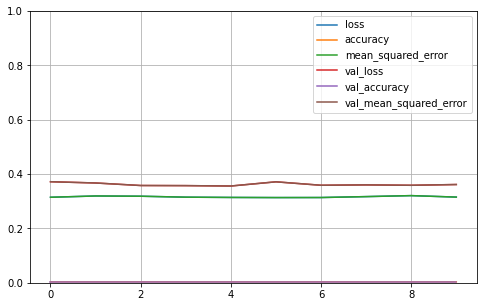

In [22]:
# 绘制图像
def plot_learning_rate(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    # 开启网格
    plt.grid(True)
    # 设置y轴范围
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_rate(history)

In [18]:
# 使用测试集验证
model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3933 - mean_squared_error: 0.3933


[0.39325717091560364, 0.39325717091560364]